In [212]:
import numpy as np 
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
np.random.seed(40)
import sklearn 
sklearn.random.seed(0)

# 1. Local Outlier Factor
This first part of the assignment will consist of implementing the LOF from the ground up.

First, we need a dataset to work with, which is created below. 

In [213]:
data, labels = make_blobs(n_samples=[100, 100, 2],random_state=42)

## Task: Understand the dataset
1. Shortly describe the dataset, and what you would expect the LOF to be of the different datapoints

## Answer

The dataset has 3 labels/classes, 202 samples. We have only 2 features which represent the coordinates of each point. 
The clusters are built according to gaussian distributions.  
I expect that the LOF will identify the outliers which are points that have a lower density than their neighbors. If the LOF(point A) is more than 1, it means that we have lower density than neighbors. Consequently A will be an outlier. 

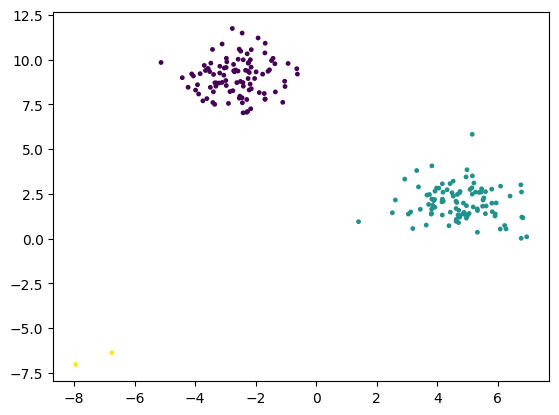

In [214]:
plt.scatter(data[:,0], data[:,1], c=labels, s=6)

## Task: implement the Local Outlier Factor
- Below are the signatures of all functions necessary for the Local Outlier Factor. Complete the implementations to fully implement the LOF.

In [215]:
#print(data)

In [216]:

def dist(x, y):
    return np.linalg.norm(x-y)

In [217]:
def k_dist(k, o, D):
    list_distances = []
    for i in D:
        d = dist(o, i)
        list_distances.append(d)
    list_distances.sort()
    return list_distances[k]

In [218]:
def N_k(k, o, D):
    list_neighbors = []
    k_dist_value = k_dist(k, o, D)
    for i in D:
        if(i[0]==o[0] and i[1]==o[1]):
            continue
        if(dist(o, i)<=k_dist_value):
            list_neighbors.append(i)
    
    return list_neighbors

In [219]:
def reach_dist(k, x, o, D):
    
    return max(k_dist(k, o, D), dist(x, o))

In [220]:
def lrd(k, o, D):
    sum_=0.
    for i in N_k(k, o, D):
        
        sum_ += reach_dist(k, o, i, D)
    num_neighbors = len(N_k(k, o, D))
    
    return (num_neighbors/sum_)

In [221]:
def lof(k, o, D):
    
    sum_= 0.
    for i in N_k(k, o, D):
        sum_ += lrd(k, i, D)/lrd(k, o, D)
    
    return sum_/(len(N_k(k, o, D)))

### Below is some helper code so you can compare your results with the LOF of the popular library scikit-learn

In [222]:
from sklearn.neighbors import LocalOutlierFactor

In [223]:
# it should work for all values of k of course
k = 5

In [224]:
my_lof_scores = np.array([lof(k, o, data) for o in data])
print(my_lof_scores[:10])

[1.03854434 1.03759892 0.94794951 1.09736105 0.98664123 1.74905378
 1.03064327 1.04210801 2.1033075  0.9904549 ]


In [225]:
sk_lof = LocalOutlierFactor(n_neighbors=k)
sk_lof.fit_predict(data)
sk_lof_scores = np.negative(sk_lof.negative_outlier_factor_)
print(sk_lof_scores[:])

[ 1.03854434  1.03759892  0.94794951  1.09736105  0.98664123  1.74905378
  1.03064327  1.04210801  2.1033075   0.9904549   1.08405434  1.06911007
  1.20690804  1.01427833  1.1503974   1.08021418  1.21297217 10.97385108
  1.16999306  1.16596947  1.27726037  1.02682042  1.11057155  1.24913594
  1.24288668  1.68891911  1.24252907  3.2560118   0.9751626   1.07680526
  1.00777373  1.05600143  2.75193139  0.96693955  1.04023598  1.13573908
  0.99776256  1.07266163  1.10929486  1.06338965  1.06107012  1.02066953
  1.43530477  0.96858783  1.30107668  1.01083739  1.10772271  1.01038793
  0.95912194  1.02493685  1.14130751  0.97601976  0.99920395  1.05906025
  1.02883493  1.1271333   1.68663616  1.31599038  1.0302527   1.03650834
  1.10645428  0.99455739  1.09894687  1.28178734  1.07224195  1.00777787
  1.35805664  1.05902296  0.97458618  0.9693305   1.19275781  0.98033916
  1.90280012  1.00935007  1.00522981  1.02234159  0.93128583  1.14985374
  1.00378278  1.26733662  1.07960953  1.01494254  1

In [226]:
# the real test: check if the LOF scores are the same
np.allclose(my_lof_scores, sk_lof_scores, rtol=0, atol=1e-8)

True

## Visualizing your LOF.
Below is your LOF calculation visualized for the dataset.

2. Is this what you expected for the LOF scores?
3. Describe in text / figures which points you consider anomalies and why?

## Answer
2. Yes, it is what I expected for the LOF score. My lof scores are equal to the sklearn lof scores indeed. 
3. The anomalies are those points which have a cirle with radius more than 1 like in the picture below. 

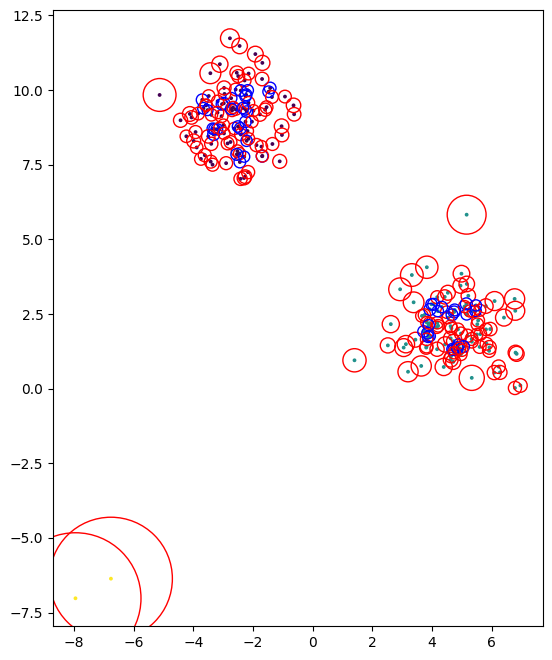

In [227]:
f, ax = plt.subplots(figsize=(14, 8))
ax.scatter(data[:,0], data[:,1], c=labels, s=3)
ax.set_aspect(1)
for i in range(len(my_lof_scores)):
    
    if my_lof_scores[i] > 1.:
        circle = plt.Circle(tuple(data[i]), my_lof_scores[i] / 5 , fill = False, edgecolor='r')
    else:
        circle = plt.Circle(tuple(data[i]), my_lof_scores[i] / 5 , fill = False, edgecolor='b')
    ax.add_artist(circle)

# 2. Isolation Forest
Next we will implement the Isolation Forest.

Again, we will use a dataset, which is created below.

In [270]:
rng = np.random.default_rng(seed=42)

# data to build forest on
data = rng.normal(loc=[2, 5, 2, 5], scale=2, size=[400, 4])
outliers = rng.normal(loc=[2, 0, 2, 0], scale=2, size=[10, 4])

# data to test with
testdata = np.vstack((rng.normal(loc=[2, 5, 2, 5], scale=2, size=[200, 4]), 
                     rng.normal(loc=[2, 0, 2, 0], scale=2, size=[20, 4])))

tainted_data = np.vstack((data, outliers))
print(data.shape, outliers.shape, testdata.shape, tainted_data.shape)



(400, 4) (10, 4) (220, 4) (410, 4)


## Implementing
Below is some skeleton code which is left for you to implement the isolation forest

In [271]:
import random
class iTree:
    def __init__(self, D, e, l):
        """
        constructs an isolation tree given the input parameters:
        
        :D: is the dataset
        :e: is the current path length
        :l: is the maximum path length
        """
        self.right = None
        self.left = None
        if(len(D)==0):
            return None
        #print("dataset: ", D)
        if(e>=l or D.shape[1]<=1):
            return None
        self.features = D.shape[1]
        self.q = random.randint(0, self.features-1)
        self.p = random.uniform(min(D[:,self.q]), max(D[:,self.q]))
        #print(p)
        D_l = [i for i in D if (i[self.q]<self.p)]
        D_r = [i for i in D if (i[self.q]>=self.p)]
        #print(np.array(D_r).shape)
        self.right = iTree(np.array(D_r), e+1, l)
        self.left = iTree(np.array(D_l), e+1, l)
    
    def test(self, o, pl = 0):
        """
        test the datapoint :o: against this tree, returns the path length
        """
        if self.left is None and self.right is None:
            return pl + 1
        
        if o[self.q] < self.p:
            return self.left.test(o, pl + 1)
        else:
            return self.right.test(o, pl + 1)
        


In [272]:
class iForest:
    def __init__(self, D, t, phi):
        """
        Constructs an Isolation Forest given the input parameters:
        
        :D: the dataset
        :t: number of isolation trees
        :phi: size of subset to take from D
        """
        self.D = D
        self.t = t
        self. phi = phi
        #self.features = D.shape[1]
        self.forest =[]
        for _ in range(t):
            D_prime = np.array(random.choices(D, k=phi))
            self.forest.append(iTree(D_prime, 0, np.log2(phi)))
            
            
        
    
    def test(self, o):
        """
        Tests the given datapoint :o: on the isolation trees and returns the average path length.
        For getting a score, I implemented the formula from the slides in function Score. 
        """
        
        self.avg_pl = 0
        for i in range(self.t):
            tree = self.forest[i]
            tree.e = tree.test(o)
            self.avg_pl+=tree.e
        return self.avg_pl/self.t
        

## Tainted vs. Untainted Datasets
- Build the isolation forest on both the untainted and the tainted dataset (for the tainted dataset just combine the data and outliers, don't use the test data)
- Plot the ROC curves for both isolation forests. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html for a function to calculate the ROC curve. Note that we take anomalies as the positive class.
1. Does it significantly affect the performance of the isolation forest? Shortly explain why it does or it doesn't.
2. A nice property of the isolation forest is that we can use subsampling without degradation in performance. How does subsampling help with masking?

## Answer
1. It seems that the tainted iForest performs worse than the untainted one. It could happen due to several factors. One can be that the tainted iForest overfits on a subset of anomalies and does not recognize anomalies outside this subset. Maybe with more instances tainted iForest can perform better. 
2. By minimizing the impact of outliers and anomalies on the model's decision boundaries and enabling the latter to concentrate on the most representative cases, subsampling in isolation forests aids in masking.

### Plotting the AUC for both models and showing those

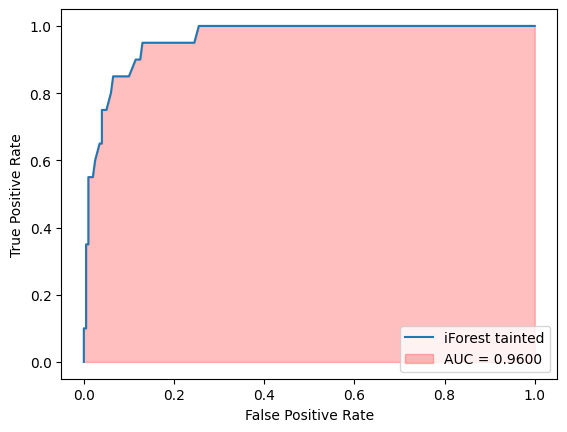

Best threshold:  1.5037743754371113e-26


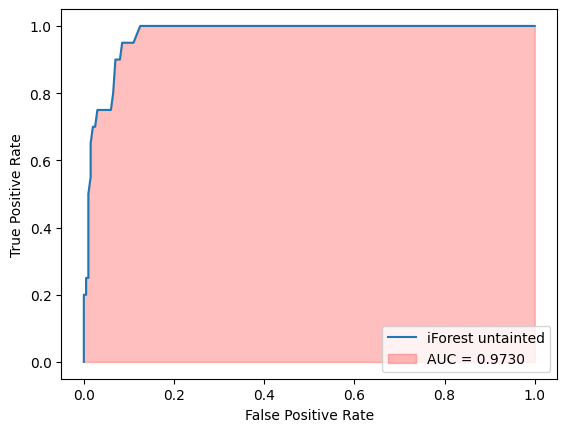

In [279]:

def Score(iforest, x):
    iforest.test(x)
    not_pl = sum(iforest.forest[i].e for i in range(iforest.t))
    c = 2*(np.log(iforest.phi-1)+0.5772156649) - (2*(iforest.phi-1)/iforest.phi)
    return 2**(-not_pl/c)
    
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, r2_score
import random
random_phi = random.randint(2, data.shape[0])
forest_tainted = iForest(tainted_data, 100, random_phi)
forest_untainted = iForest(data, 100, random_phi)
predictions = []
y_true = np.array([0]*200 + [1]*20)
for data_point in testdata:
    predictions.append(Score(forest_tainted, data_point))


fpr_tainted, tpr_tainted, _ = roc_curve(y_true,  predictions)
#print(predictions)

# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr_tainted, tpr=tpr_tainted, estimator_name='iForest tainted')
roc_display.plot()
auc_roc = auc(fpr_tainted, tpr_tainted)
plt.fill_between(fpr_tainted, tpr_tainted, alpha=0.25, color='r', label='AUC = %0.4f' % auc_roc)
plt.legend()
plt.show()



predictions = []
for data_point in testdata:
    predictions.append(Score(forest_untainted, data_point))

fpr_untainted, tpr_untainted, thresholds = roc_curve(y_true,  predictions)
auc_roc = auc(fpr_untainted, tpr_untainted)


r2_scores = [r2_score(y_true, predictions >= t) for t in thresholds]
best_threshold = thresholds[np.argmax(r2_scores)]
print('Best threshold: ', best_threshold)
# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr_untainted, tpr=tpr_untainted, estimator_name='iForest untainted')
roc_display.plot()
plt.fill_between(fpr_untainted, tpr_untainted, alpha=0.25, color='r', label='AUC = %0.4f' % auc_roc)
plt.legend()
plt.show()



As one can see, the AUC (area under the curve)of the untainted iForest is slightly larger than the tainted one.

## Task: Understanding the hyperparameters
3. Play around with the hyperparameters. How small / large can you subsample before your performance starts to decrease? Why? How many trees do you need in the forest?

## Answer
As one can see, the AUC is improved by using the number of trees equal to 10 and a phi = 100 (about 25% of the dataset ). I used random phi and a range of trees between 10 and 100. The performance seem to descrese when we increase the number of phi. 
Increasing the number of trees seems to decrease the performance of the model probably due to the fact that the model has overfitted. 

## Tuning the hyperparameters

In [274]:

# forest_tainted = iForest(tainted_data, 100, None)
# forest_untainted = iForest(data, 100, None)
random_phis = [int(400/i) for i in range(1, 5)]

best_phi = random_phis[0]
best_score = -100.
best_n_trees = 0
best_predictions = []

counter =0
tree_array={}
for trees in range(10, 100):
    if(trees%15==0):
        print("trying with ", trees, " trees")
        
    scores=[]
    for phi_ in random_phis:
        if(trees%15==0):
            print("trying with phi = ", phi_)
            
        forest_untainted = iForest(data, trees, phi_)
        predictions = []
        for data_point in testdata:
            predictions.append(Score(forest_untainted, data_point))
        score = sum(predictions)/phi_
        scores.append(score)
        
        
        if (score > best_score):
            best_score = score
            best_n_trees = trees
            best_phi = phi_
            best_predictions=predictions
    tree_array[trees]=scores
        
print(
    f"best score: {best_score}, with {best_n_trees} trees,and phi = {best_phi}")





trying with  15  trees
trying with phi =  400
trying with phi =  200
trying with phi =  133
trying with phi =  100
trying with  30  trees
trying with phi =  400
trying with phi =  200
trying with phi =  133
trying with phi =  100
trying with  45  trees
trying with phi =  400
trying with phi =  200
trying with phi =  133
trying with phi =  100
trying with  60  trees
trying with phi =  400
trying with phi =  200
trying with phi =  133
trying with phi =  100
trying with  75  trees
trying with phi =  400
trying with phi =  200
trying with phi =  133
trying with phi =  100
trying with  90  trees
trying with phi =  400
trying with phi =  200
trying with phi =  133
trying with phi =  100
best score: 0.003699350781980766, with 10 trees,and phi = 100


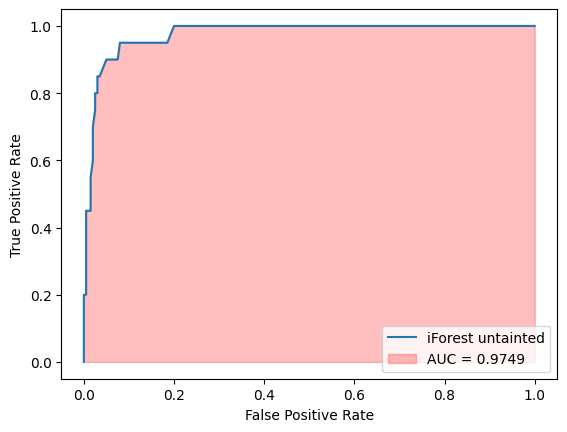

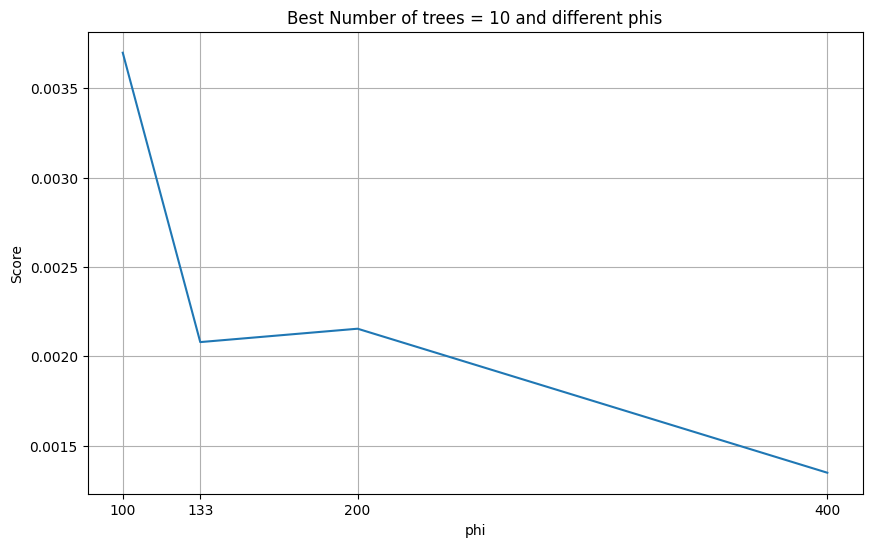

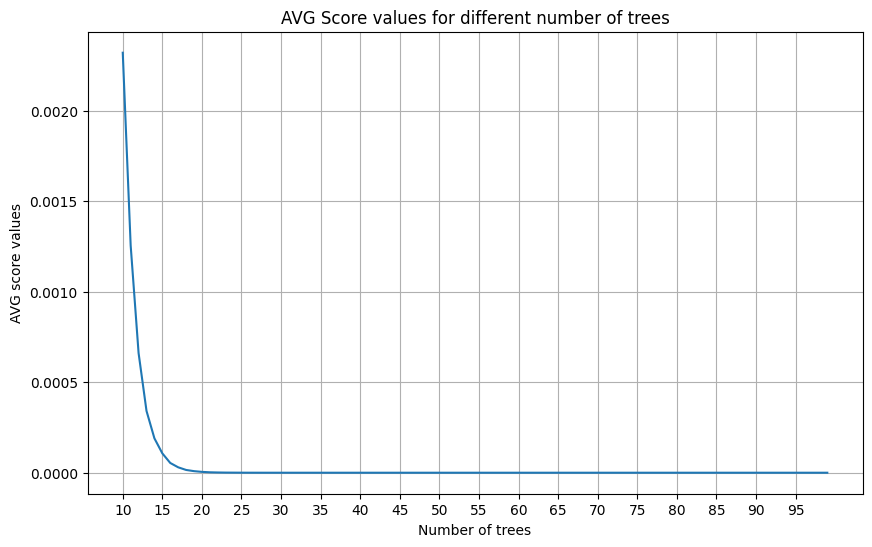

In [275]:
fpr, tpr, thresholds = roc_curve(y_true,  predictions)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='iForest untainted')
roc_display.plot()
auc_roc = auc(fpr, tpr)
plt.fill_between(fpr, tpr, alpha=0.25, color='r', label='AUC = %0.4f' % auc_roc)
plt.legend()
plt.show()
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(random_phis, tree_array[best_n_trees], label='Score')
ax.set_xticks(random_phis)
ax.set_xlabel('phi')
ax.set_ylabel('Score')
ax.grid()
ax.set_title(f'Best Number of trees = {best_n_trees} and different phis')
plt.show()
fig, ax = plt.subplots(figsize=(10, 6))
items = [v for _, v in tree_array.items() if v != 0]

avg_vals=[]
for i in items:
    
    avg_vals.append(sum(i)/len(i))

ax.plot(list(range(10, 100)), avg_vals, label='AVG Score')
ax.set_title(f'AVG Score values for different number of trees')
ax.set_xlabel('Number of trees')
ax.set_ylabel("AVG score values")
ax.grid()
ax.set_xticks(list(range(10, 100, 5)))
plt.show()


## Task: Building a detector
We now have an isolation forest which can give a measure of anomalousness for a given datapoint. But how are we going to use it to detect anomalies?

4. Using a threshold, create a detector which given a datapoint indicates whether it is anomalous or not. It should return a 1 if it is an anomaly, and a 0 if it is normal data.
    - NOTE: Motivate why you choose your threshold using metrics
    
## Answer
I used as threshold the ${R^2}$ metrics since we are dealing with a regression model (this metrics is the proportion of the variation in the dependent variable that is predictable from the independent variable). I took the best threashold which optimise this metrics. 

errors tainted model 13, untainted 13


Text(0.5, 1.0, "Detectors' Misclassifications")

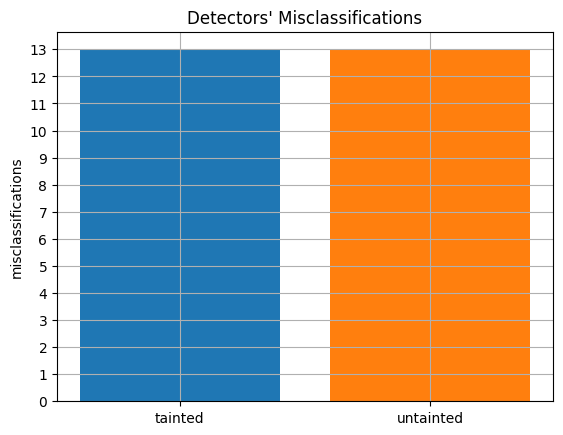

In [276]:
def detect(datapoint, threshold, iforest):
    """
    Returns 1 if the given datapoint is an anomaly, 0 otherwise.
    """

    if(Score(iforest, datapoint) >= threshold):
        return 1
    else:
        return 0

detected_anomalies_tainted=[]
detected_anomalies_untainted=[]
for data_point in testdata:
    
    detected_anomalies_tainted.append(detect(data_point, best_threshold, forest_tainted))
    detected_anomalies_untainted.append(detect(data_point, best_threshold, forest_untainted))
#print(detected_anomalies_tainted)
#print(detected_anomalies_untainted)
check_tainted, check_untainted = np.array(detected_anomalies_tainted-y_true), np.array(detected_anomalies_untainted-y_true)
misclass_tainted = np.count_nonzero((check_tainted==-1) | (check_tainted==1))
misclass_untainted = np.count_nonzero((check_untainted==-1) | (check_untainted==1))
plt.bar("tainted", misclass_tainted)
plt.ylabel("misclassifications")
print(f"errors tainted model {misclass_tainted}, untainted {misclass_untainted}" )
plt.bar("untainted", misclass_untainted)
plt.yticks(list(range(max(misclass_tainted, misclass_untainted)+1)))
plt.grid()
plt.title("Detectors' Misclassifications")
    

## Task: Evaluate
Now we want to evaluate the performance of your detector.
- Calculate the True Positive Rate, False Positive Rate, and Precision for your detector based on the output of the confusion matrix. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix for how to use the function, and see https://en.wikipedia.org/wiki/Confusion_matrix for how to calculate the metrics.
   - NOTE: do NOT use some other convenience function from sklearn or elsewhere to calculate these metrics. These may only be used to validate your metrics.

5. Are you happy with the performance of the model? Why or why not?

## Answer
- Write your answers here

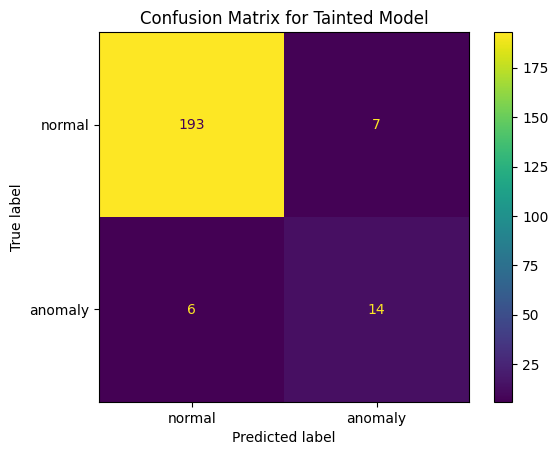

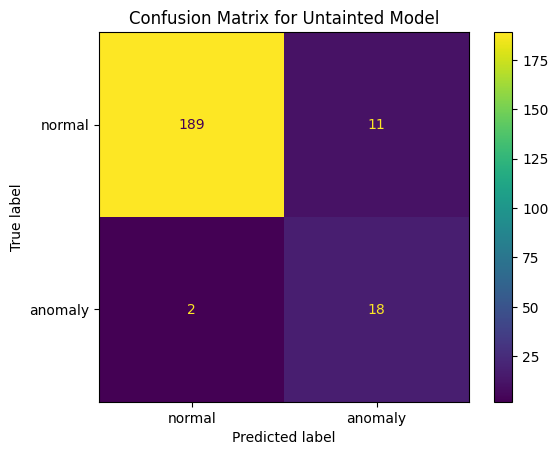

Precision Score (tainted) 0.6666666666666666
Precision (Not sklearn)  0.6666666666666666
Precision Score (Untainted) 0.6206896551724138
Precision (Not sklearn)  0.6206896551724138
FPR (tainted) 0.035 , TPR (tainted) 0.965
FPR (untainted) 0.055 , TPR (untainted) 0.945


In [295]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
CM_tainted=confusion_matrix(y_true, detected_anomalies_tainted)
disp = ConfusionMatrixDisplay(CM_tainted,display_labels=["normal", "anomaly"])
disp.plot()
plt.title("Confusion Matrix for Tainted Model")
plt.show()
CM_untainted=confusion_matrix(y_true, detected_anomalies_untainted)
disp = ConfusionMatrixDisplay(CM_untainted,display_labels=["normal", "anomaly"])
disp.plot()
plt.title("Confusion Matrix for Untainted Model")
plt.show()
tn, fp, fn, tp = CM_tainted.ravel()
print("Precision Score (tainted)", precision_score(y_true, detected_anomalies_tainted))
print("Precision (Not sklearn) ",float(CM_tainted.ravel()[3])/(CM_tainted.ravel()[3]+CM_tainted.ravel()[1]) )
print("Precision Score (Untainted)", precision_score(y_true, detected_anomalies_untainted))
print("Precision (Not sklearn) ",float(CM_untainted.ravel()[3])/(CM_untainted.ravel()[3]+CM_untainted.ravel()[1]) )
print("FPR (tainted)", fp/200., ", TPR (tainted)", 1.-fp/200.)
tn, fp, fn, tp = CM_untainted.ravel()
print("FPR (untainted)", fp/200., ", TPR (untainted)", 1.-fp/200.)


# 3. Machine Learning for Temporal Anomaly Detection
We will now look at the case of temporal data. For temporal data, it is possible to use any conventional Machine Learning model in order to perform anomaly detection. We start by creating a simple dataset below. We inject an anomaly towards the end of the dataset which will be included in the test dataset.

(1000,)


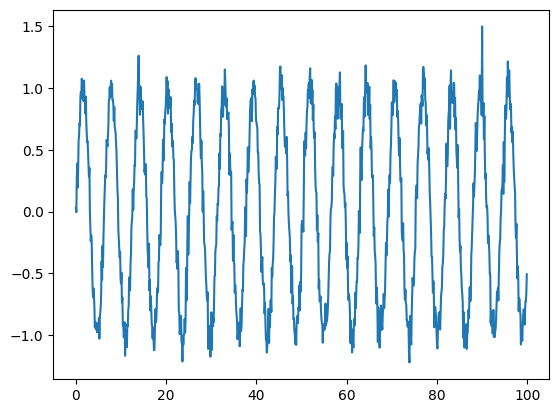

In [ ]:
rng = np.random.default_rng(seed=42)
y = np.sin(np.arange(0, 100, 0.1)) + rng.normal(loc=0, scale=0.1, size=1000) ## 1000 points
y[900] = 1.5 # outlier
train = y[:800] # 80% of the data
test = y[800:]  # 20% of the data
plt.plot(np.arange(0, 100, 0.1), y)
print(y.shape)
#print(train)

## Question
I have created this simple dataset by using a sine function and adding some gaussian-distributed noise. 
1. Is this training dataset tainted or untainted? Explain why or why not.

## Answer
I believe this dataset is untrainted because the only anomaly is the 900th sample of the test set. 

## Task: Set up the training
We will use a ML algorithm with a sliding window to try and predict the next value based on the last 24.
- transform the train and test datasets into appropriate shapes to train the model
- the model should take the last 24 datapoints (X) to predict the next datapoint (Y)

(776, 24)
[ 0.88259097  0.69810263  0.78421965  0.68019087  0.46678291  0.50885874
  0.41780033  0.51307006  0.32694556  0.14050579  0.06468455 -0.0557261
 -0.17979092 -0.36550075 -0.3675513  -0.51872249 -0.65637335 -0.56213975
 -0.64992809 -0.93663313 -0.83156535 -0.77287512 -0.81095406 -0.84956281]
True
(776,)
(800,)
(176, 24)
(176,)
(200,)


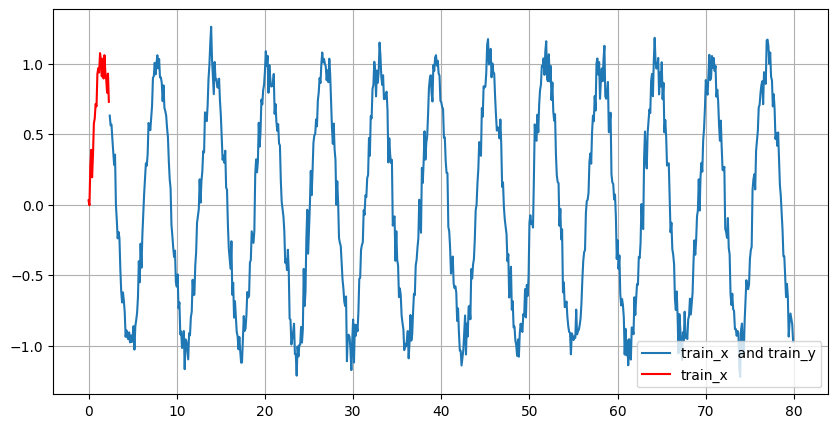

In [ ]:


train_x = np.array([train[i:i+24] for i in range(len(train)-24)])
#print(train_x)
print(train_x.shape)
print(train_x[-1])
print(train_x[-1][0]==train[-25])
train_y = train[24:]

print(train_y.shape)
print(train.shape)
test_x = np.array([test[i:i+24] for i in range(len(test)-24)]) 
test_y = test[24:]


#print("first 24 elements train x ", train_x[:24])
#print("prediction 0 ", train_y[0])
#print("original dataset train ", train[24])
#print(train_x[24:48])
#print(train_y[1])
#print(train[48])
#plt.plot(, train_x) """
print(test_x.shape)
print(test_y.shape)
print(test.shape)

    


plt.figure(figsize=(10, 5))
plt.plot(np.arange(2.4, 80, 0.1), train_y, label='train_x  and train_y')

plt.plot(np.arange(0, 2.4, 0.1), train_x[0], color='red', label='train_x') 
plt.legend()
plt.grid()
plt.show()


## Task: Train the model
Now that we have the datasets set up properly, we can train our model. Let's use a random forest regressor. 
- Train the random forest regressor on the train dataset
- Use the trained random forest regressor to make predictions on the test dataset

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, explained_variance_score
model = RandomForestRegressor(random_state=0)

model.fit(train_x, train_y)
#print(model.predict(test_x)-test_y)

print(explained_variance_score(test_y, model.predict(test_x)))
print(r2_score(test_y, model.predict(test_x)))


0.973780182325981
0.9737724161409153


## Task: Plot your predictions
Let's see visually how the model performs. 
- Plot the predictions of your model against the actual values.
2. Does your model perform well?
3. Do you think it matters for this set-up if the training dataset is tainted or untainted? Why?

## Answer
1. The model seems to perform dicently because it really simple to see the anomaly by comparing the testset and the predictions. Morever, the anomaly is visible on figure 2 at the corresponding residual. 
2. I could happen that if the training set was tainted, the model would have learnt how to predict the anomalies. Since we do not want that, it is better if the dataset is untainted as it is indeed. 

(176,)
(25,)


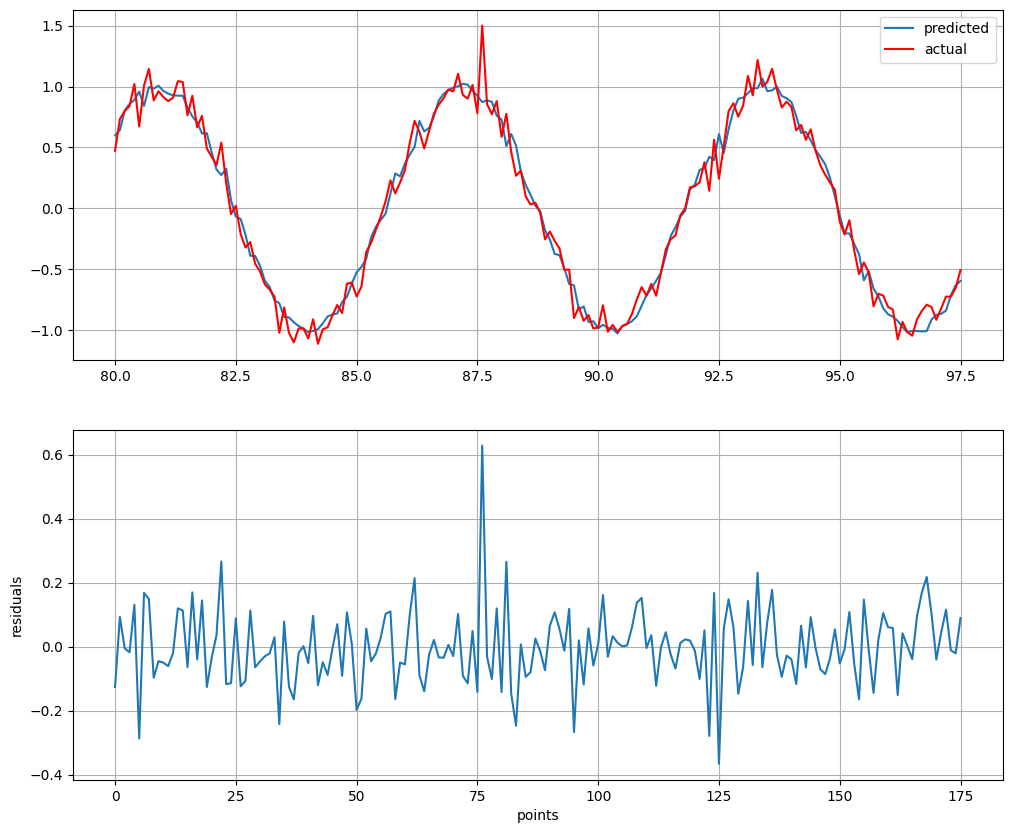

In [ ]:
print(model.predict(test_x).shape)
fig, ax = plt.subplots(2,1, figsize=(12,10))
ax[0].plot(np.arange(80, 100, 0.1)[:-24], model.predict(test_x), label='predicted')
ax[0].plot(np.arange(80, 100, 0.1)[:-24], (test_y), color='red', label='actual')
ax[0].grid()
ax[0].legend()
ax[1].plot(test_y-model.predict(test_x))
ax[1].grid()
ax[1].set_xlabel("points")
ax[1].set_ylabel("residuals")
print(np.arange(97.5, 100, 0.1).shape)
plt.show()

## Task: plot the prediction residual. 
To actually detect the anomalies, we need to calculate the residual. 
- Calculate the residual and plot it.
4. Does the residual look useful for detecting anomalies?
- Check if the injected anomaly can be detected using your residual score without giving any false positives

## Answer
It is possible to detect it as I explained above in the previous answer.


# 4. Autoencoder for Anomaly Detection
Lastly, we will use an autoencoder on the same temporal dataset to detect anomalies. Although we will use it now in a temporal setting, note that autoencoders can also be used to detect anomalies in non-temporal data.

In [ ]:
import torch
torch.device("mps")

device(type='mps')

## Task: Create train / test dataset
We will use the autoencoder slightly differently. Let's pretend that this dataset is the temperature at our nuclear reactor. We take a measurement every hour and we upload this data once per day to our server, at which point we use the autoencoder to detect anomalies.
- transform the train and test datasets into appropriate shapes to train the model
- the model should take a window of 24 datapoints and reconstruct it. The stride should be 24.

In [306]:
#train_x = np.array([train[i:i+24] for i in range(len(train))])

train_x = np.array([train[i:i+24] for i in range(0, len(train), 24)][:-8])
print(train_x.shape)
print(test.shape)
train_x = torch.from_numpy(train_x).float().to("mps")
test_x = np.array([test[j:j+24] for j in range(0, len(test), 24)][:-1])
print(test_x.shape)
test_x = torch.from_numpy(test_x).float().to("mps")

(26, 24)
(200,)
(8, 24)


## Task: Train the autoencoder
Below I have provided a simple autoencoder class which you can use.
- Use the MSE loss and the Adam optimizer to train an autoencoder on the training dataset you created.

In [377]:
class Autoencoder(torch.nn.Module):
    def __init__(self, latent_nodes):
        super().__init__()
        self.latent_nodes = latent_nodes
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(24, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, latent_nodes)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_nodes, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 15),
            torch.nn.ReLU(),
            torch.nn.Linear(15, 24)
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [361]:
# TODO: training loop
print(train_x.shape)
def training_epoch(model, train_x, optimizer, loss_fn, verbose=True):
    running_loss = 0.
    last_loss = 0.
    losses=[]
    iterations=0
    for i, data in enumerate(train_x):
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, data)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())
        iterations+=1
        if i % 13== 0:
            last_loss = running_loss / 13.
            running_loss = 0.
            if(verbose):
                print(f'batch {i%13} loss: {last_loss}')
            
    
    return last_loss, losses, iterations

torch.Size([26, 24])


batch 0 loss: 0.061319405833880104
batch 12 loss: 0.5588066751758257
batch 11 loss: 0.552704282104969
Epoch 0 loss: 0.552704282104969
batch 0 loss: 0.05882669985294342
batch 12 loss: 0.5400169963637987
batch 11 loss: 0.5355905219912529
Epoch 1 loss: 0.5355905219912529
batch 0 loss: 0.056948065757751465
batch 12 loss: 0.5229948163032532
batch 11 loss: 0.5133079389731089
Epoch 2 loss: 0.5133079389731089
batch 0 loss: 0.052761649092038475
batch 12 loss: 0.49886631468931836
batch 11 loss: 0.47486935555934906
Epoch 3 loss: 0.47486935555934906
batch 0 loss: 0.04368601739406586
batch 12 loss: 0.45511262367169064
batch 11 loss: 0.40978482117255527
Epoch 4 loss: 0.40978482117255527
batch 0 loss: 0.028695580859978993
batch 12 loss: 0.3981284238398075
batch 11 loss: 0.3413502698143323
Epoch 5 loss: 0.3413502698143323
batch 0 loss: 0.015717993179957073
batch 12 loss: 0.35711721889674664
batch 11 loss: 0.30532094836235046
Epoch 6 loss: 0.30532094836235046
batch 0 loss: 0.010938582321008047
batch 12

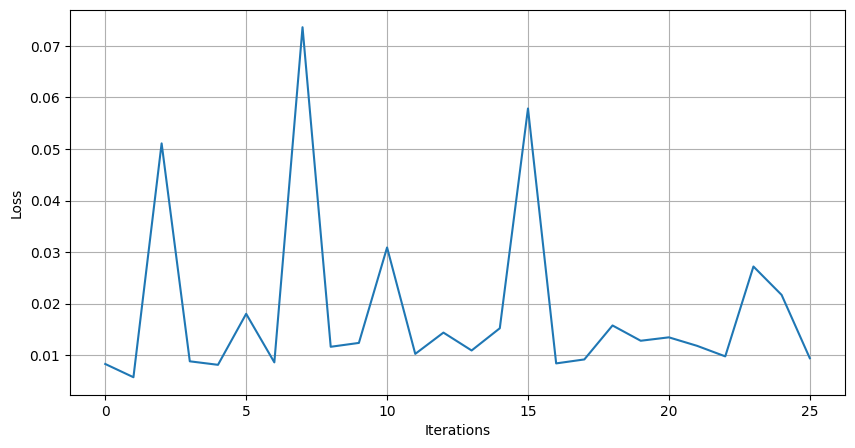

In [340]:
#EPOCHS = 10
model = Autoencoder(2).to("mps")
loss_fn = torch.nn.MSELoss().to("mps")
optimizer = torch.optim.Adam(model.parameters())
epoch=0
avg_loss=10000
losses =[]
iterations=0

while(avg_loss>0.02):
    model.train(True)
    avg_loss, losses, iterations = training_epoch(model, train_x, optimizer, loss_fn)
    
    print(f'Epoch {epoch} loss: {avg_loss}')
    epoch+=1
plt.figure(figsize=(10, 5))
plt.plot(list(range(iterations)), losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.show()


<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.021457519207615405
(192,)


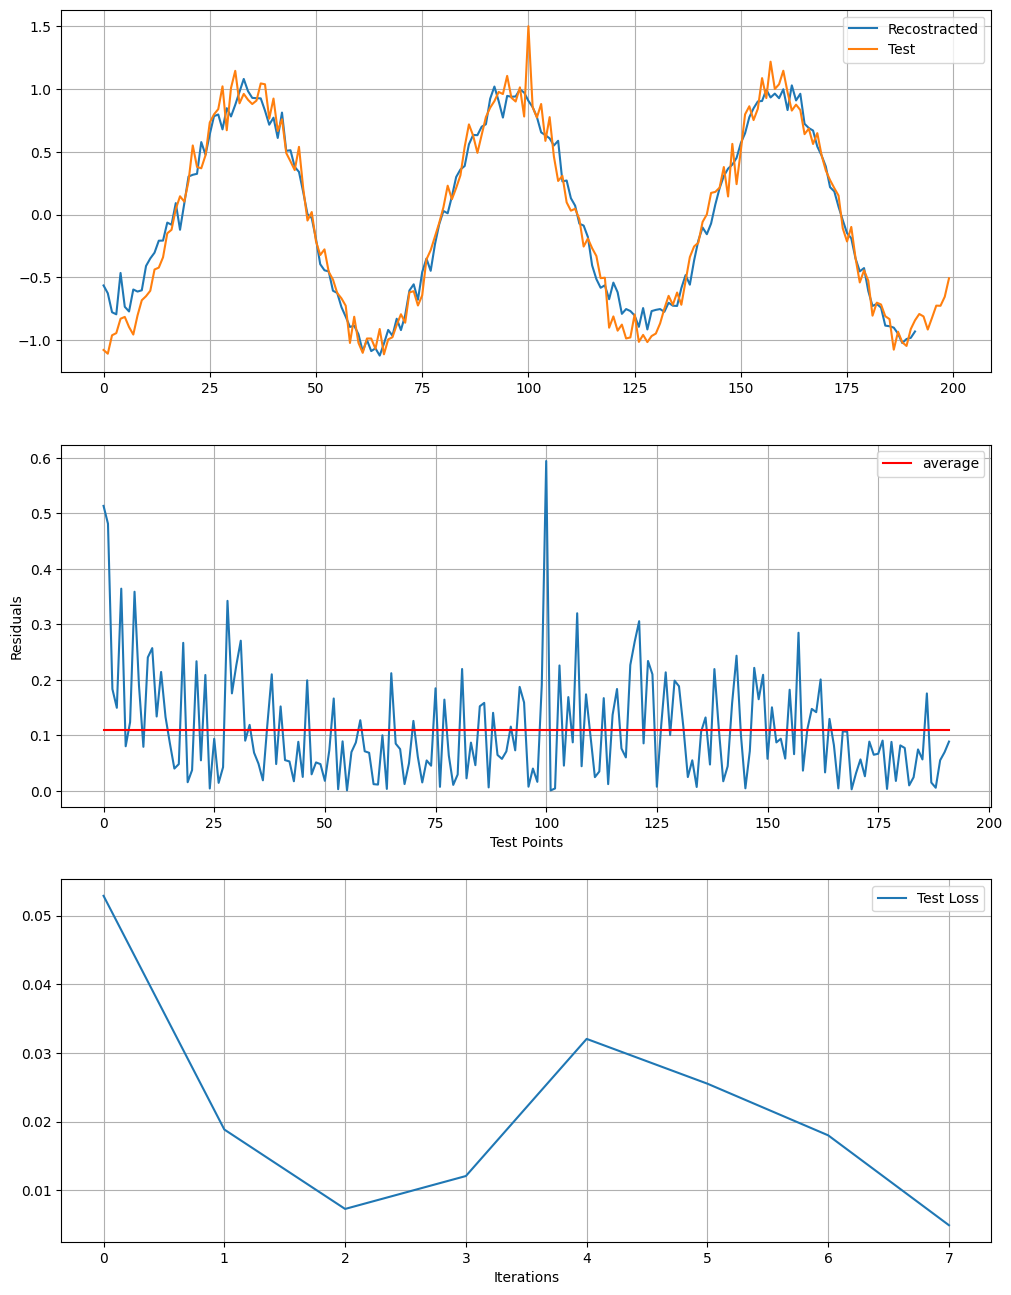

In [341]:
from torch import Tensor
model.eval()
print(type(test))
print(test_x.shape)
test_loss =0.
recostracted_data = []
test_losses =[]
with torch.no_grad():
    
    for data in test_x:
        out = model(data)
        recostracted_data.append(torch.Tensor.cpu(out).numpy())
        loss = loss_fn(out, data)
        test_losses.append(Tensor.cpu(loss).numpy())
        test_loss += loss.item()
    print("AVG LOSS ", test_loss/len(test_x))
    
recostracted_data=np.array(recostracted_data).flatten()
print(recostracted_data.shape)
fig, ax = plt.subplots(3, 1, figsize=(12, 16))
ax[0].plot(recostracted_data, label="Recostracted")
ax[0].grid(), ax[1].grid()
ax[0].plot(test, label="Test")
ax[0].legend()
ax[1].plot(abs(test[:192]-recostracted_data))
ax[1].plot(np.full(192, np.average(abs(test[:192]-recostracted_data))),  color='r', label="average")
ax[1].legend()
ax[1].set_xlabel("Test Points")
ax[1].set_ylabel("Residuals")


ax[2].plot(list(range(len(test_losses))), test_losses, label="Test Loss")
ax[2].set_xlabel("Iterations")
ax[2].grid()
ax[2].legend()
plt.show()


## Task: Plotting
Once you have achieved a loss you are happy with (should be below or around 0.02), apply the autoencoder to the test dataset and plot the reconstructed data.
Next, plot the reconstruction error on the test dataset. 
1. Is the reconstruction error useful to detect the anomaly?
2. Which approach do you prefer for temporal data: to use ML to predict next values, or to use an autoencoder to reconstruct the data? Why?
3. There are a couple of hyperparameters which you had to figure out to train an accurate model (number of nodes in latent space, learning rate, number of epochs). Describe how the number of nodes in the autoencoder affects the performance of the model using plots.

## Answer
1. It is. we can see that we have a pick in the reconstruction error at the 900th sample (fourth batch).
2. To me it seems that both models perform well. However, the Autoencoder could be a good choise since it is also used for denoising the data. By doing so, we can notice that the recontructed data does not have anomalies, and ideed detect where are they. 

## TUNING

trying with  2  nodes
for 2 nodes, loss is 0.018930253357841417 after 30 epochs
trying with  3  nodes
for 3 nodes, loss is 0.017355642854594268 after 30 epochs
trying with  4  nodes
for 4 nodes, loss is 0.019225567794190004 after 37 epochs
trying with  5  nodes
for 5 nodes, loss is 0.019198842131747648 after 24 epochs
trying with  6  nodes
for 6 nodes, loss is 0.01957581314043357 after 17 epochs
trying with  7  nodes
for 7 nodes, loss is 0.01624397037980648 after 26 epochs
trying with  8  nodes
for 8 nodes, loss is 0.01891605033037754 after 28 epochs
trying with  9  nodes
for 9 nodes, loss is 0.018959346370628245 after 26 epochs
trying with  10  nodes
for 10 nodes, loss is 0.01792506744655279 after 22 epochs
trying with  11  nodes
for 11 nodes, loss is 0.016744208092299793 after 22 epochs
trying with  12  nodes
for 12 nodes, loss is 0.019336885414444484 after 18 epochs
trying with  13  nodes
for 13 nodes, loss is 0.019468160131229803 after 27 epochs
trying with  14  nodes
for 14 nodes,

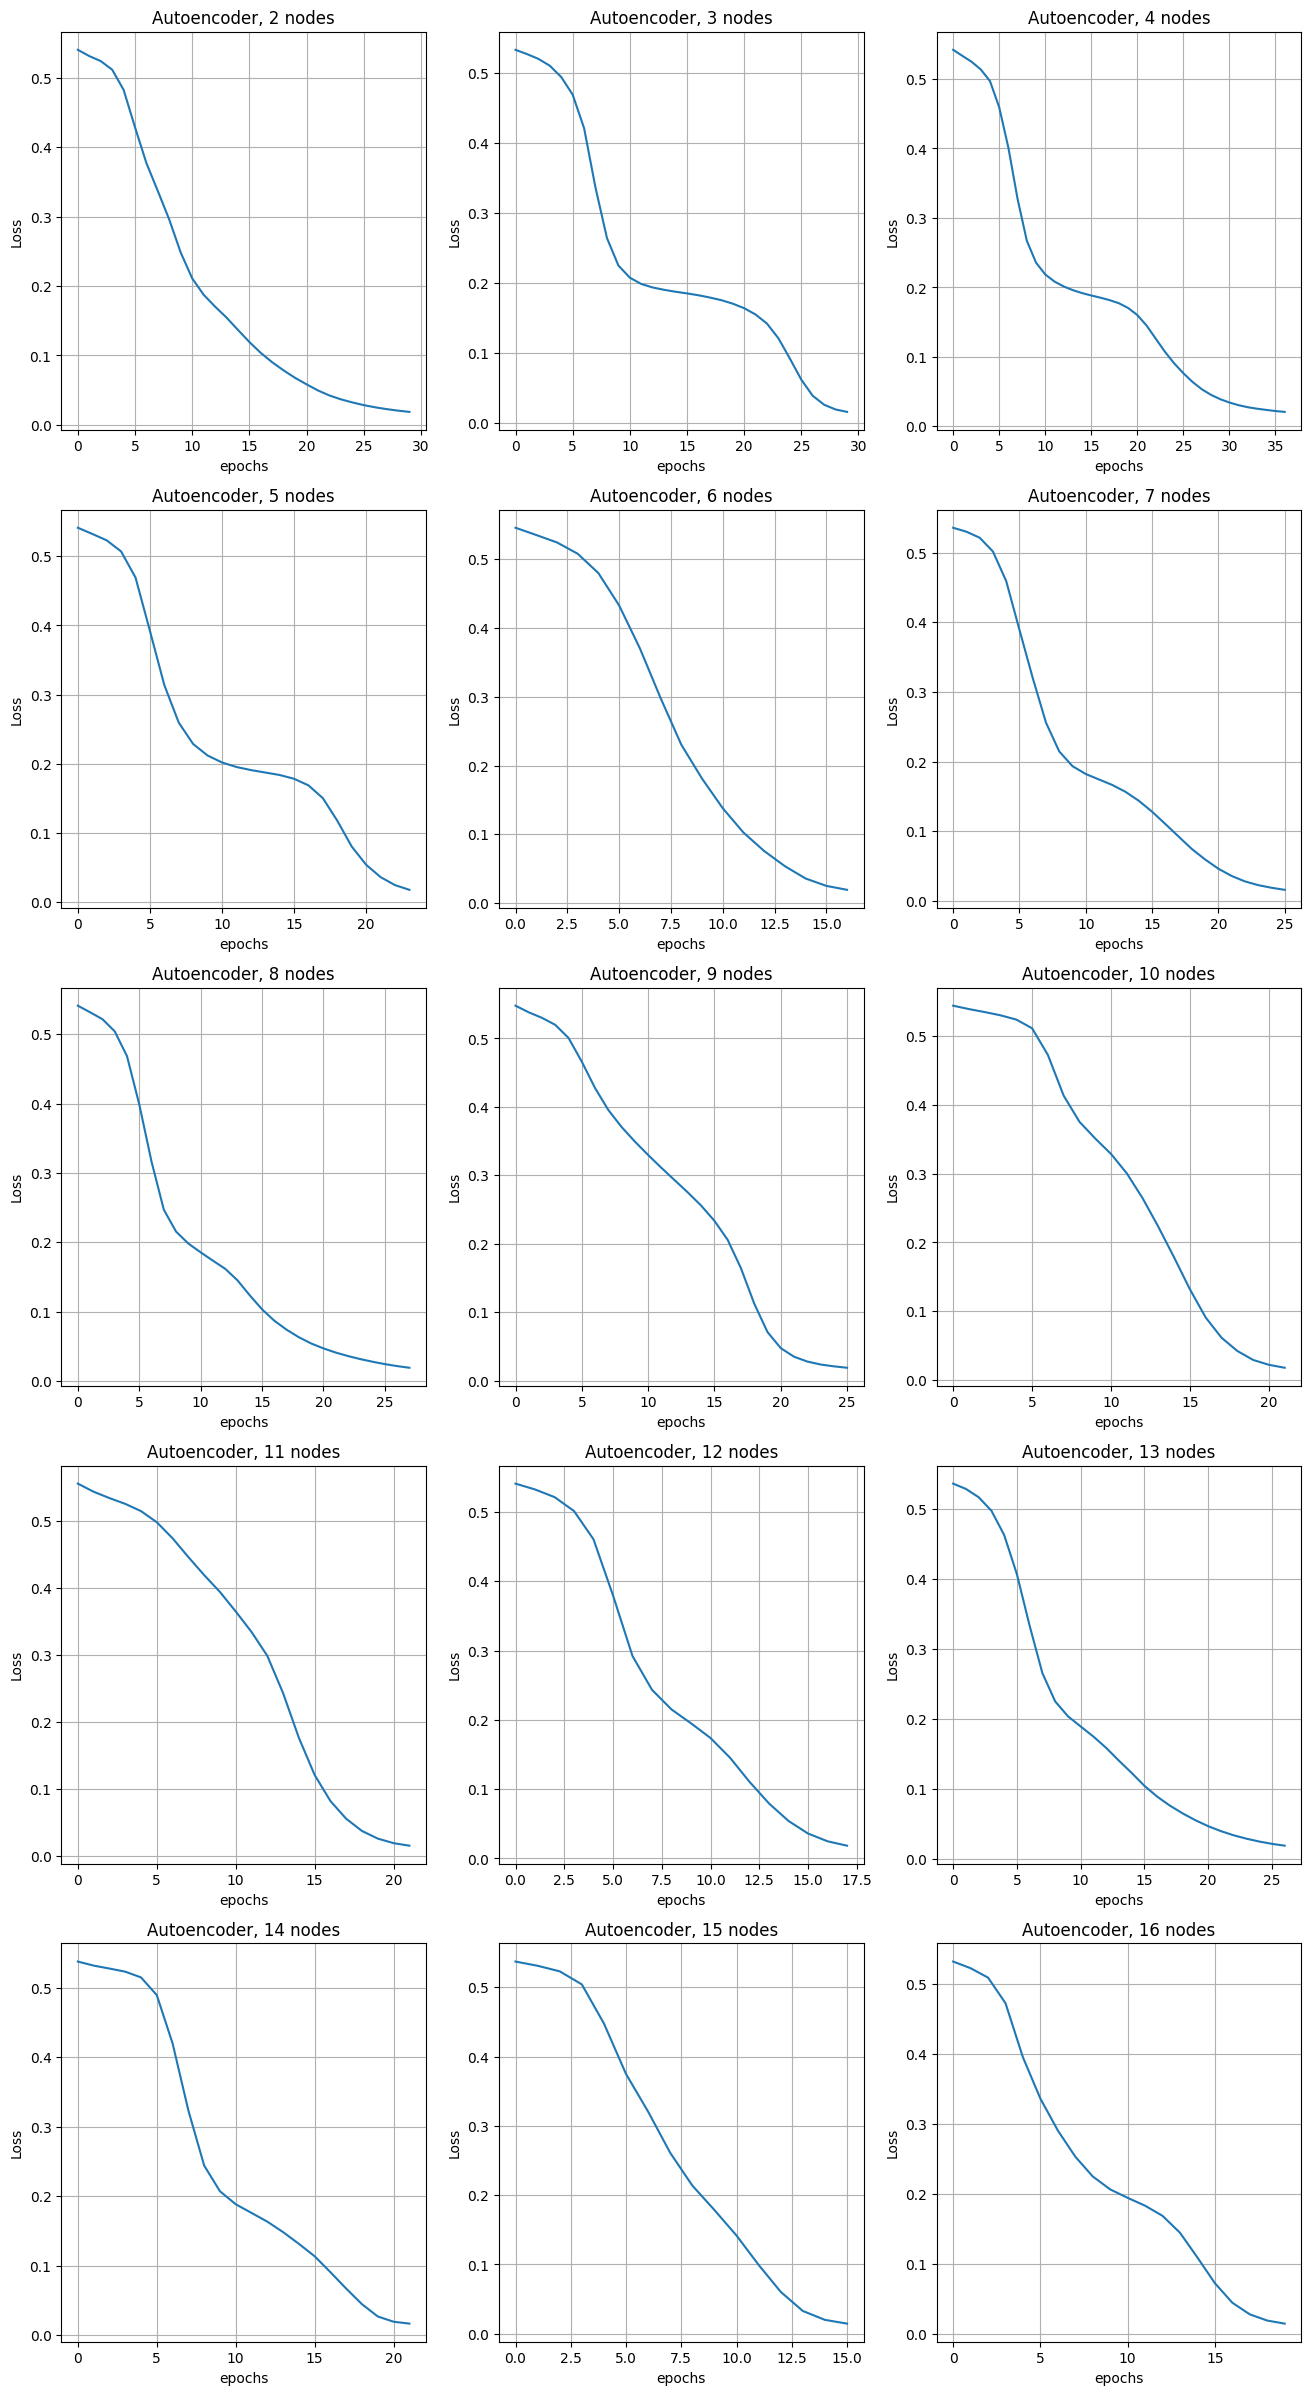

In [380]:
#del model, optimizer, loss_fn
fig, ax = plt.subplots(5, 3, figsize=(16, 30))
row , col =0, 0
Autoencoders=[]
loss_functions=[]
for number_nodes in range(2, 17):
    print("trying with ", number_nodes, " nodes")
    model = Autoencoder(number_nodes).to("mps")
    loss_fn = torch.nn.MSELoss().to("mps")
    
    optimizer = torch.optim.Adam(model.parameters())
    epoch=0
    last_loss=10000
    losses =[]
    iterations=0
    avg_loss=[]
    while(last_loss>0.02):
        model.train(True)
        last_loss, losses, iterations = training_epoch(model, train_x, optimizer, loss_fn, verbose=False)
        #print(last_loss)
        avg_loss.append(sum(losses)/len(losses))
        #print(f'Epoch {epoch} loss: {avg_loss}')
        epoch+=1
    print(f'for {number_nodes} nodes, loss is {last_loss} after {epoch} epochs')

    #print(avg_loss)
    ax[row, col].plot(list(range(len(avg_loss))), avg_loss)
    ax[row, col].set_xlabel("epochs")
    ax[row, col].set_ylabel("Loss")
    ax[row, col].grid()
    ax[row, col].set_title(f"Autoencoder, {number_nodes} nodes")
    
    col+=1
    if(col==3):
        col =0
        row+=1
    Autoencoders.append(model)
    loss_functions.append(loss_fn)
    del model, optimizer, loss_fn

plt.show()

<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.016664732480421662
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.018583181547001004
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.028394684195518494
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.018660093541257083
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.01727846421999857
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.01587390201166272
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.01944372139405459
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.023549234145320952
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.017930647591128945
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.017411813663784415
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.019178086309693754
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.020752051495946944
<class 'numpy.ndarray'>
torch.Size([8, 24])
AVG LOSS  0.018457266909535974
<class 'numpy.ndarray'>
torc

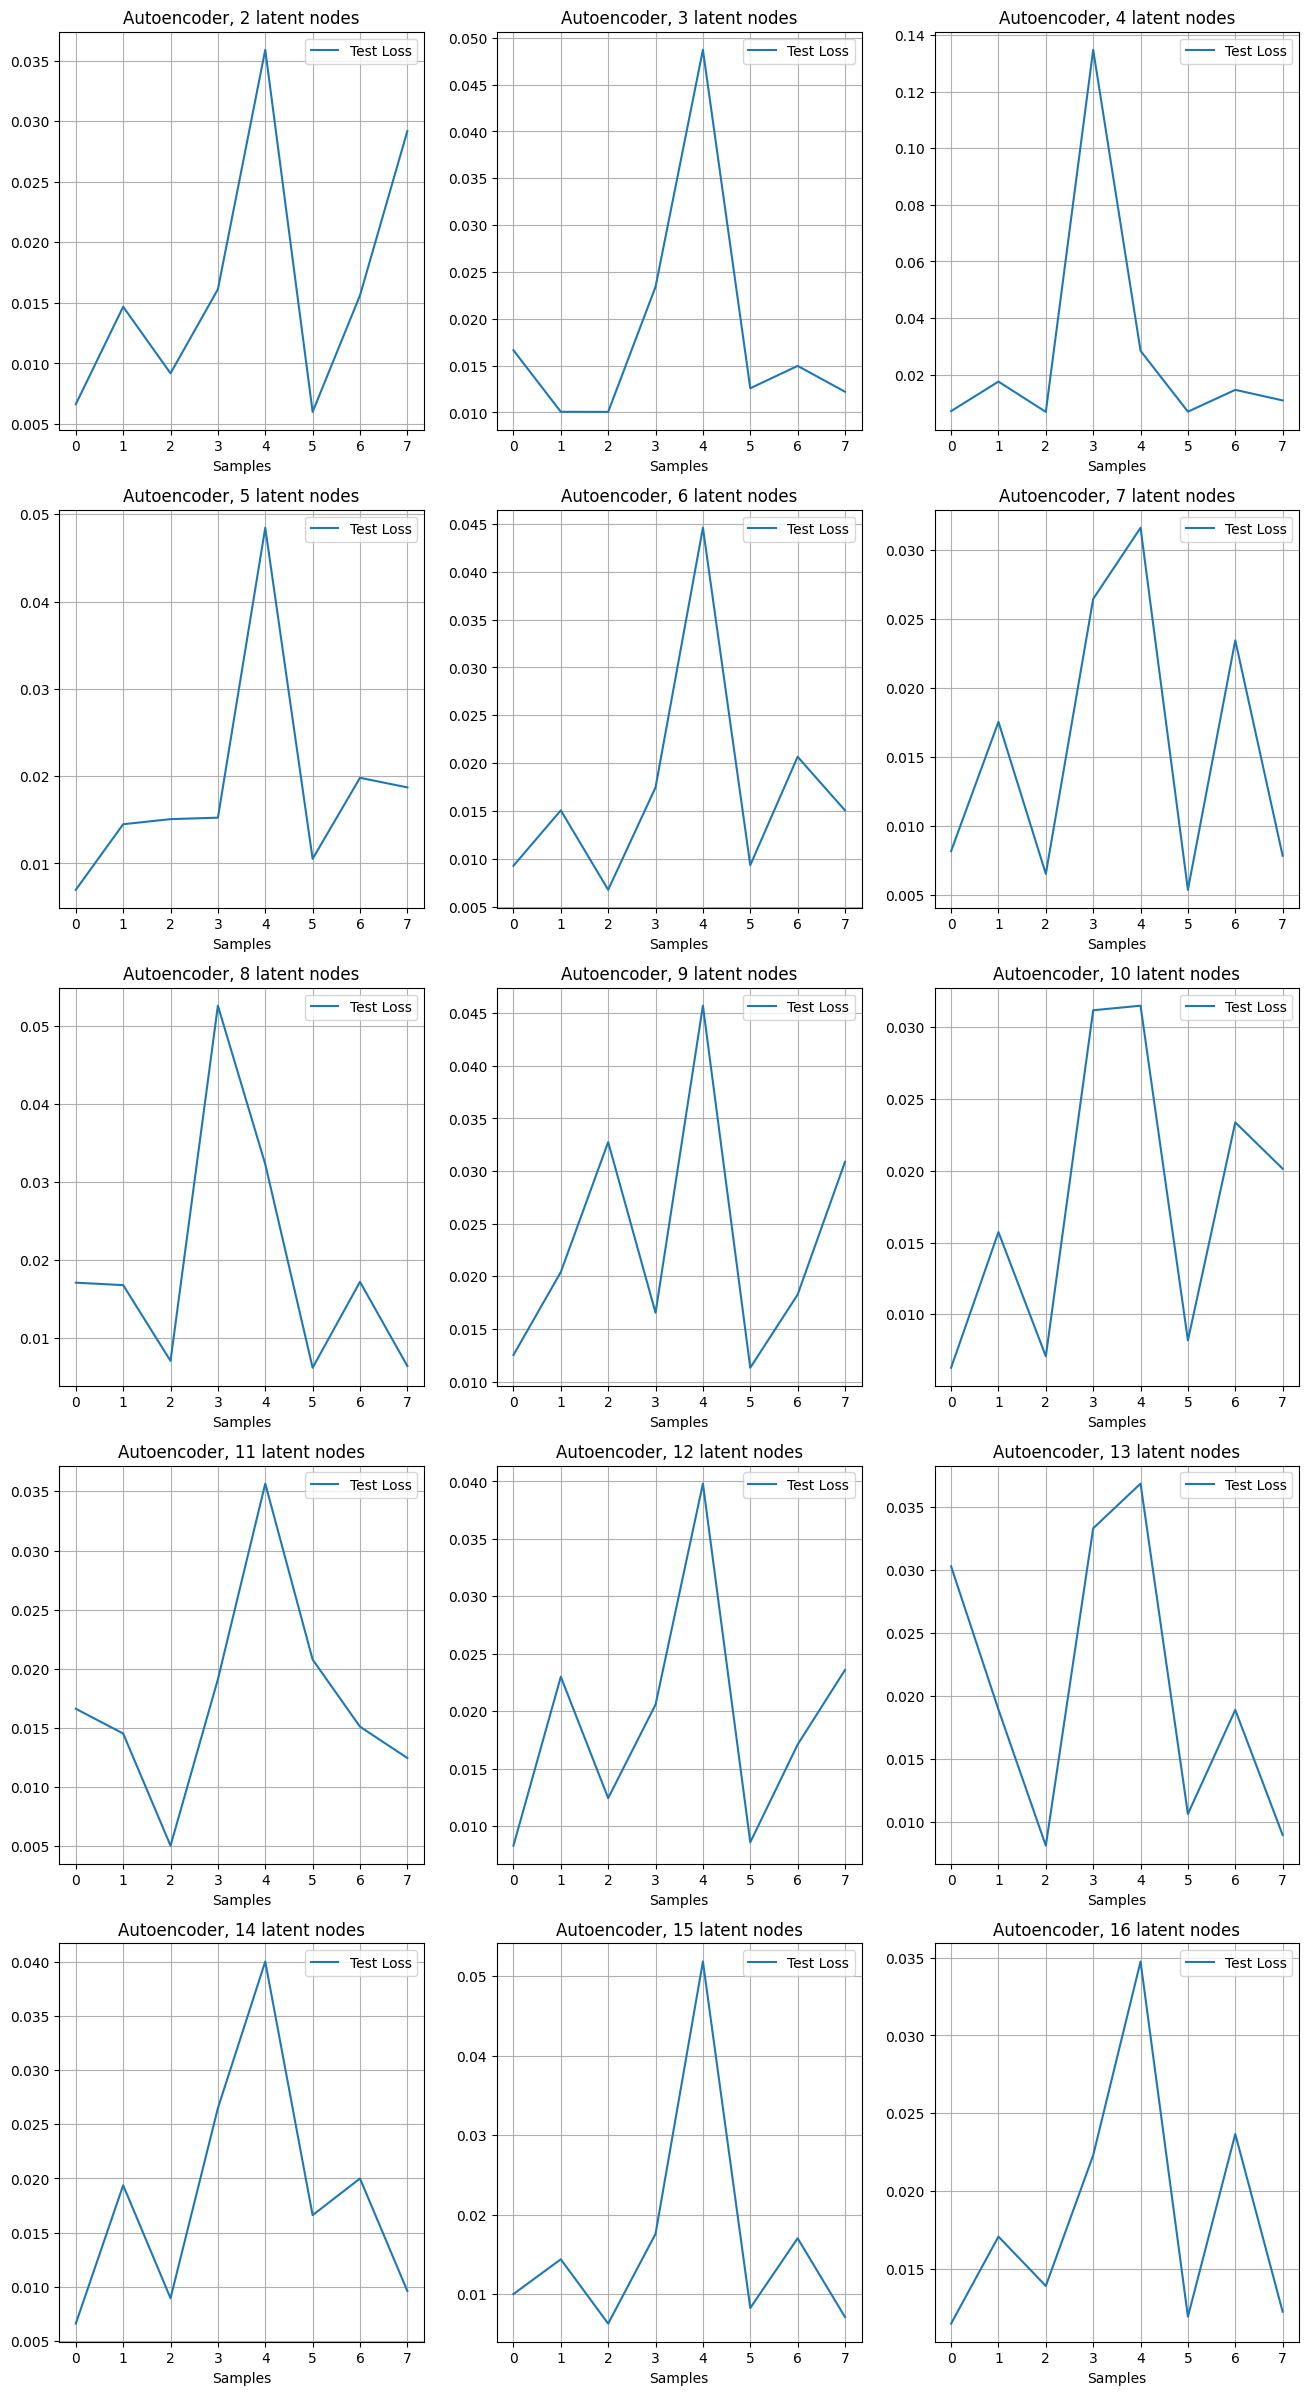

In [381]:
row, col =0, 0
fig, ax = plt.subplots(5, 3, figsize=(16, 30))
for model, loss_fn in zip(Autoencoders, loss_functions):
    model.eval()
    print(type(test))
    print(test_x.shape)
    test_loss =0.
    recostracted_data = []
    test_losses =[]
    with torch.no_grad():
        
        for data in test_x:
            out = model(data)
            recostracted_data.append(torch.Tensor.cpu(out).numpy())
            loss = loss_fn(out, data)
            test_losses.append(Tensor.cpu(loss).numpy())
            test_loss += loss.item()
        print("AVG LOSS ", test_loss/len(test_x))
    
    ax[row, col].plot(list(range(len(test_losses))), test_losses, label="Test Loss")
    ax[row, col].set_xlabel("Samples")
    ax[row, col].grid()
    ax[row, col].legend()
    ax[row, col].set_title(f"Autoencoder, {model.latent_nodes} latent nodes")
    col+=1
    if(col==3):
        col =0
        row+=1
plt.show()